In [1]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
from bounding_box import bounding_box as bb
%matplotlib inline

In [2]:
#display function to show image on Jupyter
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

In [3]:
#Load the COCO class labels in which our YOLO model was trained on
yolov4_folder = "yolov4_config"
labelsPath = os.path.join(yolov4_folder, "classes.names")
LABELS = open(labelsPath).read().strip().split("\n")
LABELS

['speed limit', 'danger', 'mandatory', 'other']

In [4]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join(yolov4_folder,"yolov4_custom_train_2000.weights")
configPath = os.path.join(yolov4_folder,"yolov4_custom_test.cfg")

# Loading the neural network framework Darknet (YOLO was created based on this framework)
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [5]:
# Create the function which predict the frame input
def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(15)
    COLORS = ["blue", "yellow", "red", "green"]
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=False, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.3
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.3)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = str(np.random.choice(COLORS, 1)[0])
            text = "{}".format(LABELS[classIDs[i]], confidences[i])
            bb.add(image,x,y,x+w,y+h,text,color)
            #cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            #cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,1, color, 2)
    return image

### Predicting single image

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


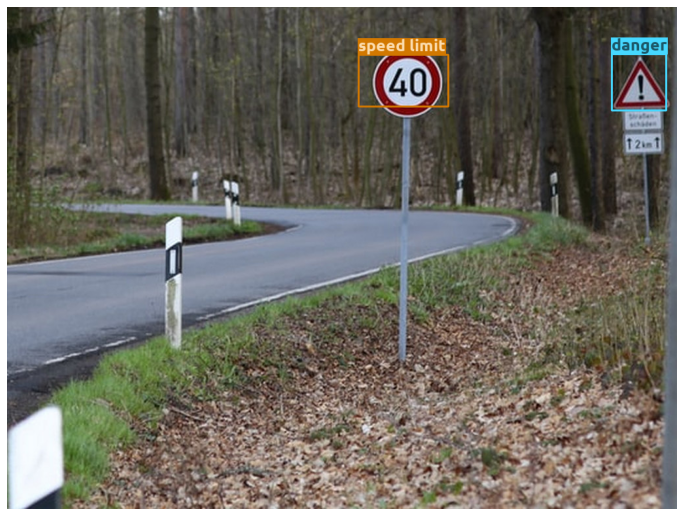

In [6]:
img = cv2.imread("examples/test_image_4.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))
#plt.savefig("./figures/yolov4_traffic_sign_detection.jpg", dpi=300)

### Predicting video

In [9]:
cap =cv2.VideoCapture('examples/test_video.mp4')

number_frame = 18.0 #higher frames better quality of the video
video_size = (1280,720)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_video_name="processed_video"
out = cv2.VideoWriter('{:s}.mp4'.format(output_video_name),fourcc, number_frame,video_size)

print("[INFO] Start processing video....")
while True:
    ret,frame = cap.read() 
    
    if ret:
        frame = cv2.resize(frame, (1280,720))
        frame = predict(frame)
        cv2.imshow("image",frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
print("[INFO] Finished! Processed video is saved as {:s}.mp4".format(output_video_name)) 

cap.release()   
out.release()
cv2.destroyAllWindows()

[INFO] Start processing video....
[INFO] Finished! Processed video is saved as yolov4_traffic_sign_detection.mp4


### Visualize our result
<p align="center"><img src="./figures/yolov4_sign_detections.gif"></img></p>

### The End!